In [47]:
import json
import matplotlib.image as pltimg
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
from PIL import Image
import numpy as np
import random

In [48]:
# Путь до файла json. Возвращает данные json файла (словарь)
def path_to_data(path):
    with open(path, "r") as read_file:
        data = json.load(read_file)
    return data

In [49]:
# Сохраняет данные (словарь) в json файл
def data_to_path(data, path):
    with open(path, 'w') as outfile:
        json.dump(data, outfile)

In [50]:
# Принимает данные json файла (словарь), возвращает их с добавленным ключом 'path' и списком команд для Марсохода
def json_data_with_path(json_data, MAX_CHARGE=100): # Принимает данный с json файла (словарь),  возвращает их с найденным путем "path"
    
    ###
    def get_next(state, data, key, n, m, reverse=False, 
             CHARGE_SHADOW=1,
             CHARGE_SUN=3,
             MOVE_ENERGY=3,
             HARD_MOVE_ENERGY=6
            ):
        x = state[0]
        y = state[1]
        c = state[2]
        rev_coef = 1
        if reverse:
            rev_coef = -1
        if key == 4:
            if data[x][y] == 4 or data[x][y] == 6:
                c += CHARGE_SHADOW * rev_coef
            else:
                c += CHARGE_SUN * rev_coef
        else:
            ground = 0
            if reverse:
                key += 2
                key %= 4
                ground = data[x][y]
            if key == 0:
                y += 1
            elif key == 1:
                x -= 1
            elif key == 2:
                y -= 1
            elif key == 3:
                x += 1
            if is_valid([x, y, c], n, m, data) and not reverse:
                ground = data[x][y]
            if ground == 3 or ground == 4:
                c -= HARD_MOVE_ENERGY * rev_coef
            else:
                c -= MOVE_ENERGY * rev_coef
        return [x, y, c]

    ###
    def is_valid(state, n, m, data, MAX_CHARGE=100):
        x = state[0]
        y = state[1]
        c = state[2]
        if not (0 <= x < n and 0 <= y < m and 0 <= c <= MAX_CHARGE):
            return False
        return data[x][y] != 1 and data[x][y] != 2

    ###
    def to_string(key):
        if key == 0:
            return "RIGHT"
        elif key == 1:
            return "UP"
        elif key == 2:
            return "LEFT"
        elif key == 3:
            return "DOWN"
        elif key == 4:
            return "CHARGE"
    
    ###
    x_start = json_data['start']['x'] - 1
    y_start = json_data['start']['y'] - 1
    x_finish = json_data['finish']['x'] - 1
    y_finish = json_data['finish']['y'] - 1
    map_mars = json_data['map']['data']
    n = json_data['map']['n']
    m = json_data['map']['m']
    INF = 1000000
    dist = [[[INF for z in range(MAX_CHARGE + 1)] for y in range(m)] for x in range(n)]
    how_got = [[[-1 for z in range(MAX_CHARGE + 1)] for y in range(m)] for x in range(n)]
    queue = deque()
    queue.append([x_start, y_start, MAX_CHARGE])
    dist[x_start][y_start][MAX_CHARGE] = 0
    while not len(queue) == 0:
        current_state = queue.popleft()
        if current_state[0] == x_finish and current_state[1] == y_finish:
            result = []
            while how_got[current_state[0]][current_state[1]][current_state[2]] != -1:
                result.append(to_string(how_got[current_state[0]][current_state[1]][current_state[2]]))
                current_state = get_next(current_state, map_mars, how_got[current_state[0]][current_state[1]][current_state[2]], n, m, reverse=True)
            json_data['path'] = list(reversed(result))
            return json_data
        for key in range(5):
            next = get_next(current_state, map_mars, key, n, m)
            if not is_valid(next, n, m, map_mars):
                continue
            x = next[0]
            y = next[1]
            c = next[2]
            curX = current_state[0]
            curY = current_state[1]
            curC = current_state[2]
            if dist[x][y][c] > dist[curX][curY][curC] + 1:
                dist[x][y][c] = dist[curX][curY][curC] + 1
                how_got[x][y][c] = key
                queue.append(next)
    json_data['path'] = 'NOT_FOUND'
    return json_data

In [51]:
# По данным json файла (словарю) возвращает изображение (np.array) карты
def get_map_image(json_data, IMAGE_SHAPE=111):
    map_of_nums = json_data['map']['data']
    map_of_nums = np.array(map_of_nums)
    n, m = json_data['map']['n'], json_data['map']['m']
    images = {}
    images[1] = pltimg.imread('images/1.png')[:, :, :3]
    images[2] = pltimg.imread('images/2.png')[:, :, :3]
    images[3] = pltimg.imread('images/3.png')[:, :, :3]
    images[4] = pltimg.imread('images/4.png')[:, :, :3]
    images[5] = pltimg.imread('images/5.png')[:, :, :3]
    images[6] = pltimg.imread('images/6.png')[:, :, :3]
    result = np.zeros((map_of_nums.shape[0] * IMAGE_SHAPE, map_of_nums.shape[1] * IMAGE_SHAPE, 3))
    for row in range(map_of_nums.shape[0]):
        column_map = np.zeros((IMAGE_SHAPE, 0, 3))
        for column in range(map_of_nums.shape[1]):
            step = np.zeros((IMAGE_SHAPE, (column_map.shape[1] + IMAGE_SHAPE), 3))
            for i in range(IMAGE_SHAPE):
                step[i] = np.concatenate((column_map[i], images[map_of_nums[row][column]][i]))
            column_map = step
        result[row * IMAGE_SHAPE:(row + 1) * IMAGE_SHAPE, :, :] = column_map
    return result

In [52]:
# По данным json файла (словарю) возвращает изображение (np.array) карты с нарисованным путем Марсохода
def get_map_image_with_path(json_data, IMAGE_SHAPE=111):
    
    
    def box_with_sign(box, sign):
        result = np.zeros_like(box)
        for row in range(box.shape[0]):
            for column in range(box.shape[1]):
                if list(sign[row][column] > 0.7) == [True, True, True]:
                    result[row][column] = box[row][column]
                else:
                    result[row][column] = sign[row][column]
        return result


    x_start = json_data['start']['x'] - 1
    y_start = json_data['start']['y'] - 1
    x_finish = json_data['finish']['x'] - 1
    y_finish = json_data['finish']['y'] - 1
    if 'path' in json_data:
        commands_list = json_data['path']
    else:
        commands_list = json_data_with_path(json_data)['path']
    if commands_list == 'NOT_FOUND':
        return 'NOT_FOUND'
    map_of_nums = json_data['map']['data']
    map_of_nums = np.array(map_of_nums)
    
    images = {}
    images[1] = pltimg.imread('images/1.png')[:, :, :3]
    images[2] = pltimg.imread('images/2.png')[:, :, :3]
    images[3] = pltimg.imread('images/3.png')[:, :, :3]
    images[4] = pltimg.imread('images/4.png')[:, :, :3]
    images[5] = pltimg.imread('images/5.png')[:, :, :3]
    images[6] = pltimg.imread('images/6.png')[:, :, :3]
    
    images['UP'] = pltimg.imread('signs/up.png')[:, :, :3]
    images['DOWN'] = pltimg.imread('signs/down.png')[:, :, :3]
    images['LEFT'] = pltimg.imread('signs/left.png')[:, :, :3]
    images['RIGHT'] = pltimg.imread('signs/right.png')[:, :, :3]
    images['CHARGE'] = pltimg.imread('signs/charge.png')[:, :, :3]
    images['FINISH'] = pltimg.imread('signs/finish.png')[:, :, :3]
    
    tmp = [commands_list[0]]
    for command in range(1, len(commands_list)):
        if not commands_list[command] == commands_list[command-1] == 'CHARGE':
            tmp.append(commands_list[command])
    commands_list = tmp
    
    cell_data = {}
    for command in commands_list:
        if not (x_start, y_start) in cell_data:
            cell_data[(x_start, y_start)] = []
        cell_data[(x_start, y_start)].append(command)
        if command == 'UP':
            x_start -= 1
        elif command == 'DOWN':
            x_start += 1
        elif command == 'LEFT':
            y_start -= 1
        elif command == 'RIGHT':
            y_start += 1
    cell_data[(x_finish, y_finish)] = ['FINISH']
    
    result = np.zeros((map_of_nums.shape[0] * IMAGE_SHAPE, map_of_nums.shape[1] * IMAGE_SHAPE, 3))
    for row in range(map_of_nums.shape[0]):
        column_map = np.zeros((IMAGE_SHAPE, 0, 3))
        for column in range(map_of_nums.shape[1]):
            if (row, column) in cell_data:
                if len(cell_data[(row, column)]) == 2:
                    tmp_img = box_with_sign(images[map_of_nums[row][column]], images[cell_data[(row, column)][1]])
                    IMG = box_with_sign(tmp_img, images['CHARGE'])
                else:
                    IMG = box_with_sign(images[map_of_nums[row][column]], images[cell_data[(row, column)][0]])
            else:
                IMG = images[map_of_nums[row][column]]
            step = np.zeros((IMAGE_SHAPE, (column_map.shape[1] + IMAGE_SHAPE), 3))
            for i in range(IMAGE_SHAPE):
                step[i] = np.concatenate((column_map[i], IMG[i]))
            column_map = step
        result[row * IMAGE_SHAPE:(row + 1) * IMAGE_SHAPE, :, :] = column_map
    
    return result

In [53]:
# По данным json файла (словарю) сохраняет изображение карты в указанный путь
def save_map_image(json_data, path_to_save):
    result = Image.fromarray((get_map_image(json_data) * 255).astype(np.uint8))
    result.save(path_to_save)

In [54]:
# По данным json файла (словарю) сохраняет изображение карты с путем Марсохода в указанный путь
def save_map_image_with_path(json_data, path_to_save):
    try:
        result = Image.fromarray((get_map_image_with_path(json_data) * 255).astype(np.uint8))
        result.save(path_to_save)
    except:
        return 'NOT_FOUND'

In [55]:
# По заданной высоте и длине генерирует новую карту
def generate_random_map(height, length):
    json_data = {}
    json_data['map'] = {}
    json_data['map']['n'] = height
    json_data['map']['m'] = length
    json_data['start'] = {}
    json_data['finish'] = {}
    map_data = [0] * (height * length)
    for i in range(height * length):
        map_data[i] = random.randint(1, 6)
    map_data = np.array(map_data).reshape((height, length)).tolist()
    json_data['map']['data'] = map_data
    return json_data

In [56]:
# По данным json файла (словарю) считает количество дней в пути, оставшийся заряд Марсохода и потраченную за весь путь энегию
def get_cost_from_json(json_data, 
                      MOVE_ENERGY = 3,
                      HARD_MOVE_ENERGY = 6,
                      CHARGE_SUN = 3,
                      CHARGE_SHADOW = 1,
                      MAX_ENERGY = 100):
    
    def calc(field, n, m, start_x, start_y, finish_x, finish_y, path, energy=MAX_ENERGY):
    
    
        def get_move(direction):
            if direction == "RIGHT":
                return 0, 1
            if direction == "LEFT":
                return 0, -1
            if direction == "DOWN":
                return 1, 0
            if direction == "UP":
                return -1, 0
            return 0, 0

    
        def energy_change(type, charging=False):
            assert type > 2
            if charging:
                if type == 4 or type == 6:
                    return -CHARGE_SHADOW
                else:
                    return -CHARGE_SUN
            # moving
            if type == 3 or type == 4:
                return HARD_MOVE_ENERGY
            # type == 5 or type == 6
            return MOVE_ENERGY

        if path == 'NOT_FOUND':
            return 'NOT_FOUND'
        x = start_x
        y = start_y
        spent_energy = 0
        for direction in path:
            (dx, dy) = get_move(direction)
            x += dx
            y += dy
            cur_change = energy_change(field[x][y], direction == "CHARGE")
            energy -= cur_change
            spent_energy += max(0, cur_change)
            energy = min(MAX_ENERGY, energy)
        return len(path), energy, spent_energy

    return calc(json_data['map']['data'], json_data['map']['n'], json_data['map']['m'],
                json_data['start']['x'] - 1, json_data['start']['y'] - 1,
                json_data['finish']['x'] - 1, json_data['finish']['y'] - 1,
                json_data['path'], MAX_ENERGY)

# Примеры использования

In [59]:
data = path_to_data('tests/test1.json')
data

{'start': {'x': 1, 'y': 1},
 'finish': {'x': 2, 'y': 4},
 'map': {'n': 3,
  'm': 5,
  'data': [[5, 3, 3, 4, 4], [4, 4, 5, 3, 3], [5, 4, 3, 3, 4]]}}

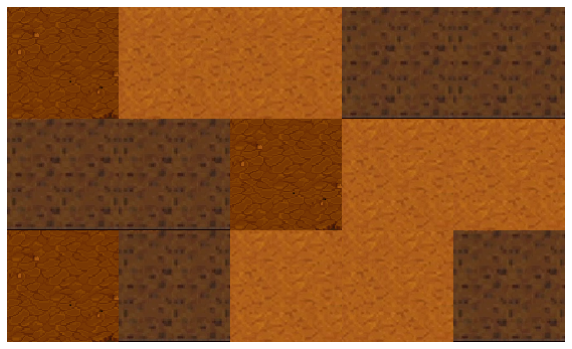

In [60]:
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(get_map_image(data));

In [61]:
save_map_image(data, 'image_examples/my_map.png')

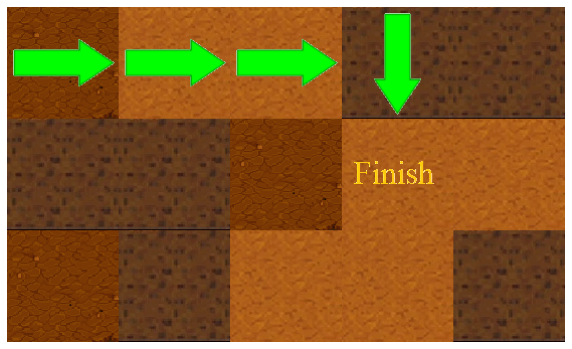

In [62]:
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(get_map_image_with_path(data));

In [63]:
save_map_image_with_path(data, 'image_examples/my_map_with_path.png')

In [64]:
tmp = get_cost_from_json(data)
print(f'Количество дней: {tmp[0]}')
print(f'Оставшийся заряд: {tmp[1]}')
print(f'Потраченная энергия: {tmp[2]}')

Количество дней: 4
Оставшийся заряд: 76
Потраченная энергия: 24


In [65]:
data = json_data_with_path(data)
data

{'start': {'x': 1, 'y': 1},
 'finish': {'x': 2, 'y': 4},
 'map': {'n': 3,
  'm': 5,
  'data': [[5, 3, 3, 4, 4], [4, 4, 5, 3, 3], [5, 4, 3, 3, 4]]},
 'path': ['RIGHT', 'RIGHT', 'RIGHT', 'DOWN']}

In [66]:
data_to_path(data, 'tests/test2.json')

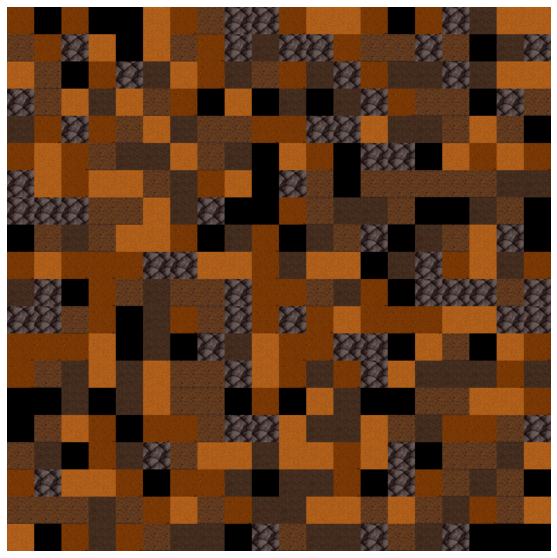

In [67]:
rand_map_data = generate_random_map(height=20, length=20)
rand_map = get_map_image(rand_map_data)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(rand_map);

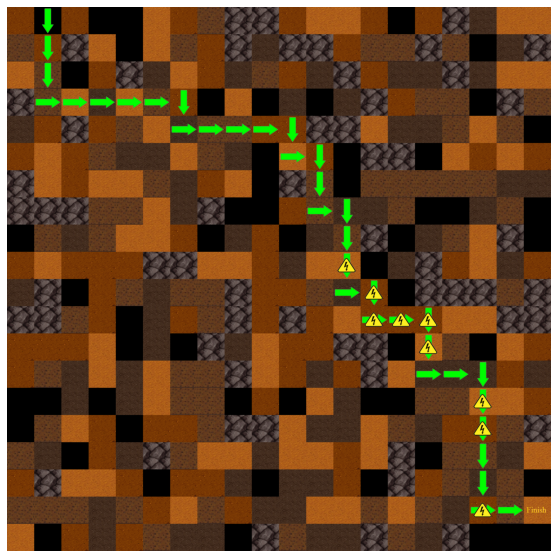

In [68]:
rand_map_data['start']['x'] = 1
rand_map_data['start']['y'] = 2
rand_map_data['finish']['x'] = 19
rand_map_data['finish']['y'] = 20
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(get_map_image_with_path(rand_map_data));

In [69]:
tmp = get_cost_from_json(rand_map_data)
print(f'Количество дней: {tmp[0]}')
print(f'Оставшийся заряд: {tmp[1]}')
print(f'Потраченная энергия: {tmp[2]}')

Количество дней: 56
Оставшийся заряд: 1
Потраченная энергия: 159
